# RL and Advanced DL: Домашнее задание 2

- Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, **в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии**. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

In [1]:
# импортируем необходимые библиотеки
import gym
import random
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
import pandas as pd
import numpy as np
from gym import spaces
from gym.utils import seeding
from copy import deepcopy
from torch.autograd import Variable
from collections import Counter, defaultdict
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


# константы для значений
CONST_NULL = 0
CONST_ONE = 1
CONST_CELL = 3
CONST_BATCH = 64
CONST_LAYER = 128

## Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны:
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

**Disclaimer**: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [2]:
class TicTacToe(gym.Env):
    def __init__(
        self,
        val_rows=CONST_CELL,
        val_cols=CONST_CELL,
        val_victory=CONST_CELL
    ):
        """
        Инициализация параметров игры и среды крестики-нолики.
        """
        self.val_rows = val_rows
        self.val_cols = val_cols
        self.val_victory = val_victory
        
        self.plate = np.zeros(
            (self.val_rows, self.val_cols),
            dtype=int
        )
        self.game_over = False
        self.plate_memory = None
        self.motion_first = CONST_ONE
        self.empty_field = None
        self.reset()

    def fill_cell_val(
        self
    ):
        """
        Заполнение значений ячеек.
        """
        if self.empty_field is None:
            res = np.where(self.plate == CONST_NULL)
            list_empty_field = []
            for i, j in zip(res[CONST_NULL], res[CONST_ONE]):
                list_empty_field.append((i, j))
            self.empty_field = np.array(list_empty_field)

        return self.empty_field

    def fill_memory_cell(
        self
    ):
        """
        Проверка значений заполнений.
        """
        if self.plate_memory is None:
            list_memory = []
            for iterr in self.plate.reshape(self.val_rows * self.val_cols):
                list_memory.append('%s' % (iterr + CONST_ONE))
            self.plate_memory = ''.join(list_memory)

        return self.plate_memory

    def transitions(
        self
    ):
        """
        Логика ходов.
        """
        transition_next = np.where(self.plate == self.motion_first)
        transition_init = self.motion_first
        for i, j in zip(transition_next[CONST_NULL], transition_next[CONST_ONE]):
            victory = False
            if i <= self.val_rows - self.val_victory:
                if np.all(self.plate[i:i + self.val_victory, j] == transition_init):
                    victory = True
            if not victory:
                if j <= self.val_cols - self.val_victory:
                    if np.all(self.plate[i, j:j + self.val_victory] == transition_init):
                        victory = True
            if not victory:
                if i <= self.val_rows - self.val_victory and j <= self.val_cols - self.val_victory:
                    list_states_plates = []
                    for k in range(self.val_victory):
                        list_states_plates.append(self.plate[i + k, j + k] == transition_init)
                    val_states_plates = np.array(list_states_plates)
                    if np.all(val_states_plates):
                        victory = True
            if not victory:
                if i <= self.val_rows - self.val_victory and j >= self.val_victory - CONST_ONE:
                    list_states_victory = []
                    for k in range(self.val_victory):
                        list_states_victory.append(self.plate[i + k, j - k] == transition_init)
                    val_states_victory = np.array(list_states_victory)
                    if np.all(val_states_victory):
                        victory = True
            if victory:
                self.game_over = True
                return self.motion_first

        if len(self.fill_cell_val()) == CONST_NULL:
            self.game_over = True
            return CONST_NULL
        
        self.game_over = False
        
        return None

    def step(
        self,
        action
    ):
        """
        Получение основных данных среды и их обновление.
        """
        if self.plate[action[CONST_NULL], action[CONST_ONE]] != CONST_NULL:
            # получаем наблюдения
            obs = (self.fill_memory_cell(), self.fill_cell_val(), self.motion_first)
            return obs, -10, True
        
        self.plate[action[CONST_NULL], action[CONST_ONE]] = self.motion_first
        self.empty_field = None
        self.plate_memory = None
        # вычисляем значение награды
        reward = self.transitions()
        self.motion_first = -self.motion_first
        # получаем наблюдения
        obs = (self.fill_memory_cell(), self.fill_cell_val(), self.motion_first)
        val_rewards = CONST_NULL if reward is None else reward
        val_dones = reward is not None
        
        return obs, val_rewards, val_dones

    def reset(
        self
    ):
        """
        Сброс значений.
        """
        self.plate = np.zeros((self.val_rows, self.val_cols), dtype=int)
        self.plate_memory = None
        self.game_over = False
        self.empty_field = None
        self.motion_first = CONST_ONE
        # получаем наблюдения
        obs = (self.fill_memory_cell(), self.fill_cell_val(), self.motion_first)
        
        return obs

In [3]:
def plot_board(
    env
):
    """
    Функция для отображения логики доски для игры.
    """
    clear_output(wait=True)
    fig, ax = plt.subplots(CONST_ONE, CONST_ONE, figsize=(8, 8))
    x_coords, y_coords = np.meshgrid(np.arange(CONST_NULL, env.val_rows), np.arange(CONST_NULL, env.val_rows))
    state, actions = env.fill_memory_cell(), env.fill_cell_val()
    ax.set_xticks([])
    ax.set_yticks([])
    image_planes = ax.imshow(np.zeros((env.val_rows, env.val_cols)) + .01, vmin=-CONST_ONE, vmax=CONST_ONE)
    for i in range(env.val_rows):
        for j in range(env.val_cols):
            if env.plate[i, j] == -CONST_ONE:
                ax.text(j, i, "O", fontsize=60, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.plate[i, j] == CONST_ONE:
                ax.text(j, i, "X", fontsize=60, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(image_planes, ticks=[CONST_NULL, CONST_ONE])
    ax.grid(True)
    plt.show()


def run_game(env):
    '''
    Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры.
    '''
    done = False
    env.reset()
    while not done:
        s, actions = env.fill_memory_cell(), env.fill_cell_val()
        if env.motion_first == CONST_ONE:
            plot_board(env)
            a = np.random.randint(len(actions))
        else:
            plot_board(env)
            a = np.random.randint(len(actions))
        observation, reward, done = env.step(actions[a])
        if reward == CONST_ONE:
            print("Победа крестиков!")
            plot_board(env)
        if reward == -CONST_ONE:
            print("Победа ноликов!")
            plot_board(env)

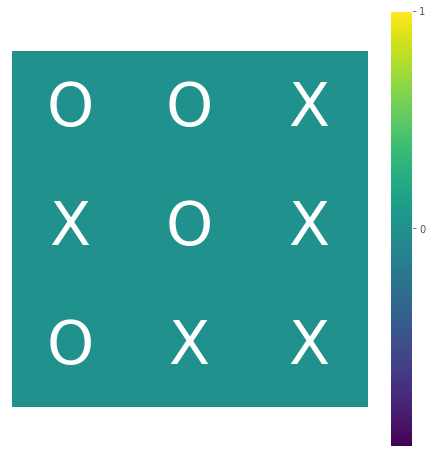

In [4]:
# выводим игру в крестики-нолики 3*3
env = TicTacToe()
run_game(env)

In [5]:
def epsilon_greedy(
    q_function,
    state,
    actions,
    eps
):
    """
    Выбираем действие эпсилон-жадным алгоритмом для состояния.
    """
    if random.random() > eps:
        straegy = actions[np.argmax(q_function[state[CONST_NULL]])]
    else:
        straegy = random.choice(actions)
        
    return straegy


def update_q_function(
    alpha,
    gamma,
    q_function,
    state,
    action,
    rewards,
    next_state=None
):
    """
    Обновление значения Q функии.
    """
    if next_state is not None:
        max_next = np.max(q_function[next_state])
    else:
        max_next = CONST_NULL
        
    return q_function[state][action] + alpha * (rewards + gamma * max_next - q_function[state][action])


def rolling_window(
    array_rewards,
    window
):
    """
    Подсчет скользящего окна для награды.
    """
    return np.lib.stride_tricks.as_strided(
        array_rewards,
        shape=array_rewards.shape[:-CONST_ONE] + (array_rewards.shape[-CONST_ONE] - window + CONST_ONE, window),
        strides=array_rewards.strides + (array_rewards.strides[-CONST_ONE],))


def val_index_array(val_array, value):
    for index, iterr in enumerate(val_array):
        if iterr == value:
            return index

    return -CONST_ONE


def q_learning(
    env,
    alpha,
    gamma,
    epsilon,
    episodes,
    shapes
):
    """
    Функция для Q обучения.
    """
    rewards = []
    env.reset()
    list_actions = env.fill_cell_val().tolist()
    q_table_state = defaultdict(lambda: np.random.uniform(size=shapes*shapes).tolist())
    for i in range(CONST_ONE, episodes):
        state = env.reset()
        reward = CONST_NULL
        done = False
        new_actions, new_states = [], []

        while not done:
            _, actions = env.fill_memory_cell(), env.fill_cell_val()
            if env.motion_first == -CONST_ONE:
                action = random.choice(actions)
            else:
                while True:
                        action = epsilon_greedy(q_table_state, state, list_actions, epsilon)
                        if action not in actions:
                            q_table_state[state[CONST_NULL]][val_index_array(list_actions, action)] = -1000
                        else:
                            break
                new_actions.append(action)

            next_state, reward, done = env.step(action) 

            if done == False:
                reward = CONST_NULL
            else:
                if env.motion_first == -CONST_ONE:
                    reward = CONST_ONE
                else:
                    reward = -CONST_ONE

                prev_state = new_states[-CONST_ONE]
                prev_action = val_index_array(list_actions, list(new_actions[-CONST_ONE]))

                q_table_state[prev_state][prev_action] = update_q_function(
                    alpha, gamma, q_table_state, prev_state, prev_action, reward, next_state[CONST_NULL]
                    )
                state = next_state
            
            if env.motion_first == CONST_ONE:
                prev_state = state[CONST_NULL]
                prev_action = val_index_array(list_actions, list(new_actions[-CONST_ONE]))

                new_states.append(prev_state)
                q_table_state[prev_state][prev_action] = update_q_function(
                    alpha, gamma, q_table_state, prev_state, prev_action, reward, next_state[CONST_NULL]
                    )
                state = next_state

        rewards.append(reward)
        
        if i % 10000 == CONST_NULL:
            clear_output(wait=True)
            plt.figure()
            plt.plot(np.mean(rolling_window(np.array(rewards), 500), CONST_ONE))
            plt.show()
            plt.close()

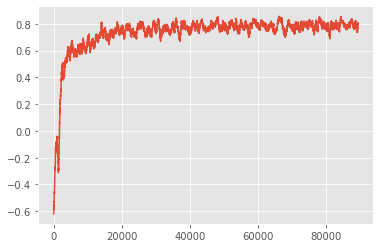

In [6]:
# для игры 3 х 3
shapes = 3
env = TicTacToe(shapes, shapes, shapes)

q_learning(env, episodes=100000, alpha=0.3, gamma=0.99, epsilon=0.06, shapes=shapes)

### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

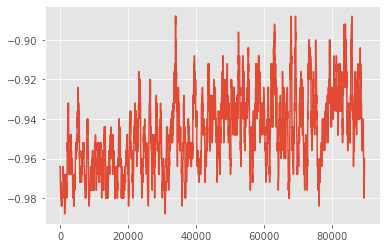

In [7]:
# 4 x 4
shapes = 4
env = TicTacToe(shapes, shapes, shapes)

q_learning(env, episodes=100000, alpha=0.3, gamma=0.99, epsilon=0.06, shapes=shapes)

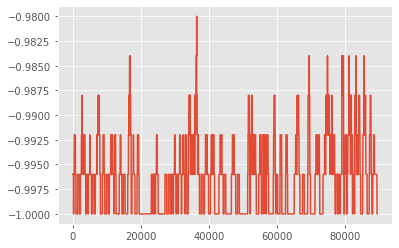

In [8]:
# 5 x 5
shapes = 5
env = TicTacToe(shapes, shapes, shapes)

q_learning(env, episodes=100000, alpha=0.3, gamma=0.99, epsilon=0.06, shapes=shapes)

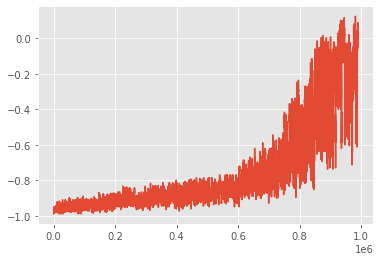

In [9]:
# поменяем не много гиперпараметры и добавим больше эпизодов
# 4 x 4
shapes = 4
env = TicTacToe(shapes, shapes, shapes)

q_learning(env, episodes=1000000, alpha=0.2, gamma=0.9, epsilon=0.04, shapes=shapes)

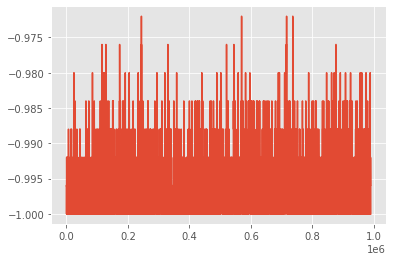

In [10]:
# поменяем не много гиперпараметры и добавим больше эпизодов
# 5 x 5
shapes = 5
env = TicTacToe(shapes, shapes, shapes)

q_learning(env, episodes=1000000, alpha=0.2, gamma=0.9, epsilon=0.04, shapes=shapes)

#### Вывод:
В целом Q-обучение с эпсилон-жадной стратегией справляется довольно хорошо на маленькой доске (3 х 3) и на небольшом количестве эпизодов прохода, но для сеток размером (4 х 4 и 5 х 5) необходимо добавить больше эпизодов прохода и видно, что для 5 х 5 уже данный подход работает не очень хорошо, благодаря Q-обучению можно добиться хороших результатов на маленьких сетках игры (3 х 3 и 4 х 4).

## Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше):

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
4. Реализуйте Double DQN и/или Dueling DQN.

### 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [11]:
class TicTacToe(gym.Env):
    def __init__(
        self,
        val_rows=CONST_CELL,
        val_cols=CONST_CELL,
        val_victory=CONST_CELL
    ):
        """
        Инициализация параметров игры и среды крестики-нолики.
        """
        self.val_rows = val_rows
        self.val_cols = val_cols
        self.val_victory = val_victory
        
        self.plate = np.zeros(
            (self.val_rows, self.val_cols),
            dtype=int
        )
        self.game_over = False
        self.plate_memory = None
        self.motion_first = CONST_ONE
        self.empty_field = None
        self.val_random = CONST_NULL
        self.plate_shape = val_rows
        self.actions = self.fill_cell_val().tolist()
        self.reset()

    def fill_cell_val(
        self
    ):
        """
        Заполнение значений ячеек.
        """
        if self.empty_field is None:
            res = np.where(self.plate == CONST_NULL)
            list_empty_field = []
            for i, j in zip(res[CONST_NULL], res[CONST_ONE]):
                list_empty_field.append((i, j))
            self.empty_field = np.array(list_empty_field)

        return self.empty_field

    def fill_memory_cell(
        self
    ):
        """
        Проверка значений заполнений.
        """
        if self.plate_memory is None:
            list_memory = []
            for iterr in self.plate.reshape(self.val_rows * self.val_cols):
                list_memory.append('%s' % (iterr + CONST_ONE))
            self.plate_memory = ''.join(list_memory)

        return self.plate_memory

    def transitions(
        self
    ):
        """
        Логика ходов.
        """
        transition_next = np.where(self.plate == self.motion_first)
        transition_init = self.motion_first
        for i, j in zip(transition_next[CONST_NULL], transition_next[CONST_ONE]):
            victory = False
            if i <= self.val_rows - self.val_victory:
                if np.all(self.plate[i:i + self.val_victory, j] == transition_init):
                    victory = True
            if not victory:
                if j <= self.val_cols - self.val_victory:
                    if np.all(self.plate[i, j:j + self.val_victory] == transition_init):
                        victory = True
            if not victory:
                if i <= self.val_rows - self.val_victory and j <= self.val_cols - self.val_victory:
                    list_states_plates = []
                    for k in range(self.val_victory):
                        list_states_plates.append(self.plate[i + k, j + k] == transition_init)
                    val_states_plates = np.array(list_states_plates)
                    if np.all(val_states_plates):
                        victory = True
            if not victory:
                if i <= self.val_rows - self.val_victory and j >= self.val_victory - CONST_ONE:
                    list_states_victory = []
                    for k in range(self.val_victory):
                        list_states_victory.append(self.plate[i + k, j - k] == transition_init)
                    val_states_victory = np.array(list_states_victory)
                    if np.all(val_states_victory):
                        victory = True
            if victory:
                self.game_over = True
                return self.motion_first

        if len(self.fill_cell_val()) == CONST_NULL:
            self.game_over = True
            return CONST_NULL
        
        self.game_over = False
        
        return None

    def step(
        self,
        action
    ):
        """
        Получение основных данных среды и их обновление.
        """
        if self.plate[action[CONST_NULL], action[CONST_ONE]] != CONST_NULL:
            # получаем наблюдения
            obs = (self.fill_memory_cell(), self.fill_cell_val(), self.motion_first)
            return obs, -10, True
        
        self.plate[action[CONST_NULL], action[CONST_ONE]] = self.motion_first
        self.empty_field = None
        self.plate_memory = None
        # вычисляем значение награды
        reward = self.transitions()
        self.motion_first = -self.motion_first
        # получаем наблюдения
        obs = (self.fill_memory_cell(), self.fill_cell_val(), self.motion_first)
        val_rewards = CONST_NULL if reward is None else reward
        val_dones = reward is not None
        
        return obs, val_rewards, val_dones

    def reset(
        self
    ):
        """
        Сброс значений.
        """
        self.plate = np.zeros((self.val_rows, self.val_cols), dtype=int)
        self.plate_memory = None
        self.game_over = False
        self.empty_field = None
        self.motion_first = CONST_ONE
        # получаем наблюдения
        obs = (self.fill_memory_cell(), self.fill_cell_val(), self.motion_first)
        
        return obs

    def random_step(
        self,
        action
        ):
        """
        Случайный шаг обновления среды.
        """
        state, reward, done = self.step(self.actions[action])
        self.val_random += CONST_ONE
        
        if not done:
            action_random = self.fill_cell_val()
            _, _, done = self.step(random.choice(action_random))
            self.val_random += CONST_ONE
            
            if done:
                # we lost
                return self.plate, -CONST_ONE, True
            else:
                # play further
                return self.plate, CONST_NULL, False
            
        else:
            if reward == -10:
                # wrong move
                return self.plate, -10, True
            else:
                if self.val_random == self.plate_shape * self.plate_shape:
                    # draw
                    return self.plate, -0.5, True
                else:
                    # we won
                    return self.plate, CONST_ONE, True
        
    def reset_rand(
        self
        ):
        """
        Обновление случайного состояния.
        """
        self.val_random = CONST_NULL
        self.reset()

        return self.plate, CONST_NULL, False

In [12]:
class ReplayMemory():
    """
    Буфер памяти.
    """
    def __init__(
        self,
        capacity
        ):
        self.capacity = capacity
        self.memory = []
        self.position = CONST_NULL

    def init_memory(
        self,
        memor
        ):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = memor
        self.position = (self.position + CONST_ONE) % self.capacity
       
    def sample(
        self,
        batch_size
        ):
        return random.sample(self.memory, batch_size)

    def __len__(
        self
        ):
        return len(self.memory)


class DQNetwork(
    nn.Module
    ):
    def __init__(
        self,
        plate_shape,
        padding_shape
        ):
        self.plate_shape = plate_shape
        nn.Module.__init__(self)
        self.conv1 = torch.nn.Conv2d(CONST_ONE, 32, plate_shape, padding=(padding_shape, padding_shape))
        self.conv2 = torch.nn.Conv2d(32, CONST_CELL, plate_shape, padding=(padding_shape, padding_shape))
        self.linear = nn.Linear(plate_shape * plate_shape * CONST_CELL, plate_shape * plate_shape)
        self.relu = nn.ReLU()

    def forward(
        self,
        x
        ):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.linear(x.view(-CONST_ONE, self.plate_shape * self.plate_shape * CONST_CELL))

        return x

In [13]:
class TTDQN():
    def __init__(
        self,
        plate_size,
        padding_size,
        ):
        self.plate_size = plate_size
        # инициализация игры в крестики-нолики
        self.env = TicTacToe(self.plate_size, self.plate_size, self.plate_size)
        # инициализация DQN
        self.model = DQNetwork(plate_size, padding_size)
        # буфер памяти
        self.memory = ReplayMemory(10000)
        # оптимизатор
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.rewards = []
        
    def run_train_game(
        self
        ):
        state, reward, done = self.env.reset_rand()
        while True:
            to_state = torch.tensor(
                state, dtype=torch.float32
                ).reshape(
                    CONST_ONE, CONST_ONE, self.plate_size, self.plate_size
                    )
            with torch.no_grad():
                action = self.model(to_state).data.max(CONST_ONE)[CONST_ONE].view(CONST_ONE, CONST_ONE)
                    
            next_state, reward, done = self.env.random_step(action.numpy()[CONST_NULL][CONST_NULL])
            next_state_tensor = torch.tensor(
                next_state, dtype=torch.float32
                ).reshape(
                    CONST_ONE, CONST_ONE, self.plate_size, self.plate_size
                    )

            transition = (
                to_state, action, next_state_tensor,
                torch.tensor([reward], dtype=torch.float32)
                )
            
            # записываем в память
            self.memory.init_memory(transition)
            if len(self.memory) < CONST_BATCH:
                return

            # батч из памяти
            transitions = self.memory.sample(CONST_BATCH)
            batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
            batch_state = Variable(torch.cat(batch_state))
            batch_action = Variable(torch.cat(batch_action))
            batch_reward = Variable(torch.cat(batch_reward))
            batch_next_state = Variable(torch.cat(batch_next_state))

            # считаем значения функции Q
            Q = self.model(batch_state).gather(CONST_ONE, batch_action).reshape([CONST_BATCH])
            # считаем q фунцияю от всех действий
            Qmax = self.model(batch_next_state).detach().max(CONST_ONE)[CONST_NULL]
            Qnext = batch_reward + (0.8 * Qmax)
            # рассчитываем потери
            loss = F.smooth_l1_loss(Q, Qnext)
            # очищаем веса градиента
            self.optimizer.zero_grad()
            # делаем шаг оптимизации и отправляем лосс для подсчета
            loss.backward()
            self.optimizer.step()
            state = next_state
            if done:
                self.rewards.append(reward)
                break

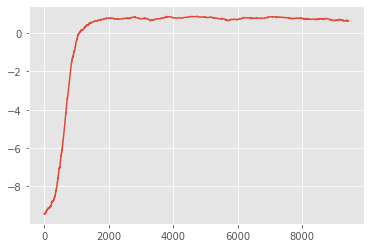

In [14]:
# инициализируем игру в крестики нолики 3 х 3 и с padding = 1
tictac_dqn = TTDQN(CONST_CELL, CONST_ONE)
# проходим 10000 эпох
for _ in range(10000):
    # 
    tictac_dqn.run_train_game()
# визуализируем значение награды
plt.figure()
plt.plot(np.mean(rolling_window(np.array(tictac_dqn.rewards), 500), CONST_ONE))
plt.show()
plt.close()

### 4. Реализуйте Double DQN и/или Dueling DQN.

In [15]:
class DuelingDQNetwork(nn.Module):
    def __init__(
        self,
        plate_shape
        ):
        super(DuelingDQNetwork, self).__init__()
        
        self.plate_shape = plate_shape
        
        self.conv = nn.Sequential(
            nn.Conv2d(CONST_ONE, 5, kernel_size=CONST_CELL, stride=CONST_ONE, padding=CONST_ONE),
            nn.ReLU()
            )
        
        self.fc_layer = self.conv(torch.zeros(CONST_ONE, CONST_ONE, self.plate_shape, self.plate_shape)).view(CONST_ONE, -CONST_ONE).size(CONST_ONE)
        
        self.layer_lin1 = nn.Sequential(
            nn.Linear(self.fc_layer, CONST_LAYER),
            nn.ReLU(),
            nn.Linear(CONST_LAYER, CONST_ONE)
        )

        self.layer_lin2 = nn.Sequential(
            nn.Linear(self.fc_layer, CONST_LAYER),
            nn.ReLU(),
            nn.Linear(CONST_LAYER, self.plate_shape * self.plate_shape)
        )

    def forward(
        self,
        state
        ):
        x = self.conv(state)
        x = x.view(x.size(0), -CONST_ONE)
        values = self.layer_lin1(x)
        return self.layer_lin1(x) + (self.layer_lin2(x) - self.layer_lin2(x).mean())

In [16]:
class TTDDQN():
    def __init__(
        self,
        plate_size
        ):
        self.plate_size = plate_size
        # инициализация игры в крестики-нолики
        self.env = TicTacToe(self.plate_size, self.plate_size, self.plate_size)
        # инициализация DQN
        self.model = DuelingDQNetwork(plate_size)
        # буфер памяти
        self.memory = ReplayMemory(10000)
        # оптимизатор
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.rewards = []
        
    def run_train_game(
        self
        ):
        state, reward, done = self.env.reset_rand()
        while True:
            to_state = torch.tensor(
                state, dtype=torch.float32
                ).reshape(
                    CONST_ONE, CONST_ONE, self.plate_size, self.plate_size
                    )
            with torch.no_grad():
                action = self.model(to_state).data.max(CONST_ONE)[CONST_ONE].view(CONST_ONE, CONST_ONE)
                    
            next_state, reward, done = self.env.random_step(action.numpy()[CONST_NULL][CONST_NULL])
            next_state_tensor = torch.tensor(
                next_state, dtype=torch.float32
                ).reshape(
                    CONST_ONE, CONST_ONE, self.plate_size, self.plate_size
                    )

            transition = (
                to_state, action, next_state_tensor,
                torch.tensor([reward], dtype=torch.float32)
                )
            
            # записываем в память
            self.memory.init_memory(transition)
            if len(self.memory) < CONST_BATCH:
                return

            # батч из памяти
            transitions = self.memory.sample(CONST_BATCH)
            batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
            batch_state = Variable(torch.cat(batch_state))
            batch_action = Variable(torch.cat(batch_action))
            batch_reward = Variable(torch.cat(batch_reward))
            batch_next_state = Variable(torch.cat(batch_next_state))

            # считаем значения функции Q
            Q = self.model(batch_state).gather(CONST_ONE, batch_action).reshape([CONST_BATCH])
            # считаем q фунцияю от всех действий
            Qmax = self.model(batch_next_state).detach().max(CONST_ONE)[CONST_NULL]
            Qnext = batch_reward + (0.8 * Qmax)
            # рассчитываем потери
            loss = F.smooth_l1_loss(Q, Qnext)
            # очищаем веса градиента
            self.optimizer.zero_grad()
            # делаем шаг оптимизации и отправляем лосс для подсчета
            loss.backward()
            self.optimizer.step()
            state = next_state
            if done:
                self.rewards.append(reward)
                break

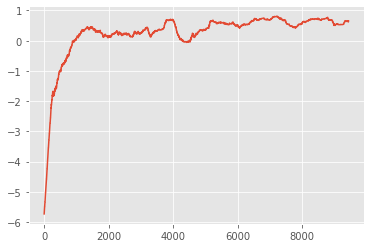

In [20]:
# инициализируем игру в крестики нолики 3 х 3 и с padding = 1 с подходом Dueling DQN
tictac_dqn = TTDDQN(CONST_CELL)
# проходим 10000 эпох
for _ in range(10000):
    tictac_dqn.run_train_game()
# визуализируем значение награды
plt.figure()
plt.plot(np.mean(rolling_window(np.array(tictac_dqn.rewards), 500), CONST_ONE))
plt.show()
plt.close()

#### Вывод: В целом подход на основе DQN и Dueling  DQN показывает хороший результат и достигают хороший результат и достигает оптимальное значение награды за маленькое количество эпох (10000), в то время как для обычного подхода на основе Q функциии требовалось около 100000 эпох. И судя по значениям наград, подход на основе Dueling DQN стабильнее обычного подхода DQN.

## Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов:

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

### 5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

In [21]:
def rollouts(
    env
    ):
    """
    Случайная стратегия.
    """
    env = deepcopy(env)
    done = env.transitions()
    while not done:
        action = random.choice(env.empty_field)
        _, reward, done = env.step(action)

    return reward

In [22]:
rewards = []
env = TicTacToe()
for _ in range(10000):
    rewards.append(rollouts(env))
print("Среднее значение для награды с подходом rollouts:", np.mean(rewards))

Среднее значение для награды с подходом rollouts: 0.3048


### 6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [23]:
class MCTS:
    """
    MCTS-поиск.
    """
    def __init__(
        self,
        env
        ):
        self.env = deepcopy(env)
        self.parent = None
        self.term = False
        self.visited = False
        self.child = []
        self.reward, self.left, self.right = CONST_NULL, CONST_NULL, CONST_NULL
        
    def search(
        self
        ):
        if self.term:
            self.left += CONST_ONE
            return -self.reward
        
        if not self.visited:
            self.visited = True
            self.reward = rollouts(self.env)
            self.right = (self.right * self.left + self.reward) / (self.left + CONST_ONE)
            self.left += CONST_ONE
            
            return self.reward
        
        if len(self.child) == CONST_NULL:
            for action in self.env.empty_field:
                new_env = deepcopy(env)
                _, rewards, done = new_env.step(action)
                new_node = MCTS(new_env)
                new_node.parent = self 
                new_node.action = action
                self.child.append(new_node)
                if done:
                    new_node.term = True
                    new_node.reward = rewards
            val = self.child[CONST_NULL].search()
            self.right = (self.right * self.left + val) / (self.left + CONST_ONE)
            self.left += CONST_ONE

            return val

In [24]:
def move_mcts(
    env,
    actions
    ):
    """
    Выбор действия с подходом MCTS.
    """
    mcts = MCTS(env)
    for _ in range(1000):
        mcts.search()
    val = max(mcts.child, key=lambda x: x.left).action
    for index, i in enumerate(actions):
        if sum(i == val) == 2:
            return index
    return -CONST_ONE


def run_game_mcts(env):
    '''
    Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры.
    '''
    done = False
    env.reset()
    while not done:
        s, actions = env.fill_memory_cell(), env.fill_cell_val()
        if env.motion_first == CONST_ONE:
            plot_board(env)
            a = move_mcts(env, actions)
        else:
            plot_board(env)
            a = move_mcts(env, actions)
        observation, reward, done = env.step(actions[a])
        if reward == CONST_ONE:
            print("Победа крестиков!")
            plot_board(env)
        if reward == -CONST_ONE:
            print("Победа ноликов!")
            plot_board(env)

    return reward

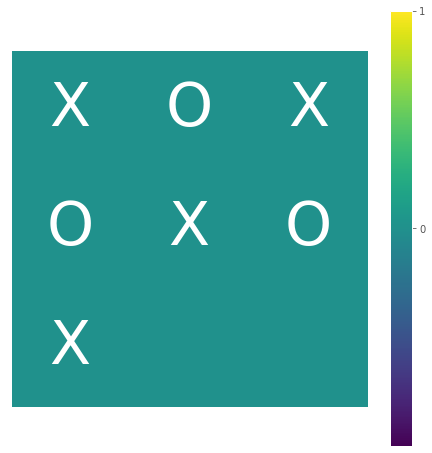

Среднее значение для награды с подходом MCTS: 1.0


In [25]:
# запустим подход на основе mcts
rewards = []
for _ in range(1000):
    env = TicTacToe()
    rewards.append(run_game_mcts(env))
print("Среднее значение для награды с подходом MCTS:", np.mean(rewards))

#### Вывод: подход на основе rollouts дает довольно плохой результат, все таки случайная стратегия в данной игре не применима. А вот подход MCTS дает лучше результат.

## Часть четвёртая, опциональная: AlphaZero

В опциональной части домашнего задания давайте попробуем всё-таки собрать всё вместе и завести настоящий AlphaZero. Если получится и будет обобщаться на большие доски, будет очень круто и будет стоить много дополнительных баллов:\

7. Реализуйте AlphaZero для крестиков-ноликов, используя MCTS из третьей части и DQN-сеть из второй части. Обучите стратегии для игры на больших досках (10х10 и выше, до пяти в ряд; опять же, может потребовать много времени, так что достаточно показать, что обучение началось и идёт).

### 7. Реализуйте AlphaZero для крестиков-ноликов, используя MCTS из третьей части и DQN-сеть из второй части. Обучите стратегии для игры на больших досках (10х10 и выше, до пяти в ряд; опять же, может потребовать много времени, так что достаточно показать, что обучение началось и идёт).